In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re
import sklearn

In [2]:
cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv("data/sentiment140/training.csv",header=None, names=cols)
df[df.sentiment.isin([0,4])]
df = df.sample(50000, random_state=1234)
df.sentiment = df.sentiment.apply(lambda x: 'Negative' if x == 0 else 'Positive')

In [3]:
df

,sentiment,id,date,query_string,user,text
1062048,Positive,1964017646,Fri May 29 13:35:57 PDT 2009,NO_QUERY,ashakur,@PcShakur I guess so. We should go make it a f...
1236895,Positive,1992914899,Mon Jun 01 09:31:47 PDT 2009,NO_QUERY,RabbiShaiSpecht,@PsychicSophie Thank you!
1237054,Positive,1992954642,Mon Jun 01 09:35:38 PDT 2009,NO_QUERY,RobinRene7,it's just another day here at the office...I a...
229979,Negative,1978627799,Sat May 30 23:57:09 PDT 2009,NO_QUERY,valfvergara,@triciasays i miss kickboxing
760772,Negative,2296927988,Tue Jun 23 09:48:35 PDT 2009,NO_QUERY,SarahAnnGreen,@AmandaFClark Thats rubbish!
...,...,...,...,...,...,...
46422,Negative,1677402582,Sat May 02 01:53:46 PDT 2009,NO_QUERY,kmac1984,wondering what the hell is gonna happen next??...
34170,Negative,1564728728,Mon Apr 20 04:42:44 PDT 2009,NO_QUERY,engers,@jkoxvold Me too
888464,Positive,1687307615,Sun May 03 08:20:39 PDT 2009,NO_QUERY,_Alectrona_,I'm off Will maybe tweet later...Bye!
292279,Negative,1995953530,Mon Jun 01 14:18:18 PDT 2009,NO_QUERY,TraceyyMartinn,stomach hurts and i desperatly want to go sho...


# Préprocessing

accents, contractions, lowercase, newlines, lemmatization, stemming


In [4]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [5]:
import time
a = time.time()
# lowercase
df.text = df.text.apply(lambda x: x.lower())   

# remove extra newlines
df.text = df.text.apply(lambda x: re.sub(r'[\r|\n|\r\n]+', ' ', x))

# remove @tag
df.text = df.text.apply(lambda x: re.sub(r'@[A-Za-z0-9]+','', x))

# remove URL
df.text = df.text.apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','', x))

# remove hashtag and numbers
df.text = df.text.apply(lambda x: re.sub("[^a-zA-Z]", " ", x))

# tokenization
df.text = df.text.apply(word_tokenize)

# # remove stop words
# stop_words = set(stopwords.words('english'))
# df.text = df.text.apply(lambda x: [word for word in x if word not in stop_words])

# lemmatization    
df.text = df.text.apply(nltk.tag.pos_tag)
df.text = df.text.apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

wordnet_lemmatizer = WordNetLemmatizer()
df.text = df.text.apply(lambda x: [wordnet_lemmatizer.lemmatize(word, tag) for (word, tag) in x])


df.text = df.text.apply(lambda x: ' '.join(word for word in x))
df
print(time.time()-a)

60.002562046051025


In [6]:
df

,sentiment,id,date,query_string,user,text
1062048,Positive,1964017646,Fri May 29 13:35:57 PDT 2009,NO_QUERY,ashakur,i guess so we should go make it a family affair
1236895,Positive,1992914899,Mon Jun 01 09:31:47 PDT 2009,NO_QUERY,RabbiShaiSpecht,thank you
1237054,Positive,1992954642,Mon Jun 01 09:35:38 PDT 2009,NO_QUERY,RobinRene7,it s just another day here at the office i be ...
229979,Negative,1978627799,Sat May 30 23:57:09 PDT 2009,NO_QUERY,valfvergara,i miss kickboxing
760772,Negative,2296927988,Tue Jun 23 09:48:35 PDT 2009,NO_QUERY,SarahAnnGreen,thats rubbish
...,...,...,...,...,...,...
46422,Negative,1677402582,Sat May 02 01:53:46 PDT 2009,NO_QUERY,kmac1984,wonder what the hell be gon na happen next
34170,Negative,1564728728,Mon Apr 20 04:42:44 PDT 2009,NO_QUERY,engers,me too
888464,Positive,1687307615,Sun May 03 08:20:39 PDT 2009,NO_QUERY,_Alectrona_,i m off will maybe tweet later bye
292279,Negative,1995953530,Mon Jun 01 14:18:18 PDT 2009,NO_QUERY,TraceyyMartinn,stomach hurt and i desperatly want to go shop ...


# Term frequency

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

vectorizer.fit(df.text)

neg_matrix = vectorizer.transform(df[df.sentiment == 'Negative'].text)
pos_matrix = vectorizer.transform(df[df.sentiment == 'Positive'].text)

In [8]:
print(df[df.sentiment == 'Negative'].iloc[1].text)
print(neg_matrix[1])
liste = vectorizer.get_feature_names()
print([liste[i] for i in neg_matrix[1].tocoo().col])

thats rubbish
  (0, 22892)	1
  (0, 26768)	1
['rubbish', 'thats']


In [9]:
neg_tf = np.sum(neg_matrix,axis=0)
pos_tf = np.sum(pos_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],
                            columns=vectorizer.get_feature_names()
                           ).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', 
                         ascending=False
                        ).iloc[:10]

,negative,positive,total
be,11029,9553,20582
to,9707,7733,17440
the,8098,8305,16403
it,5652,5173,10825
my,5925,3986,9911
and,4926,4633,9559
you,3198,6186,9384
have,4449,3240,7689
in,3739,3245,6984
for,3070,3673,6743


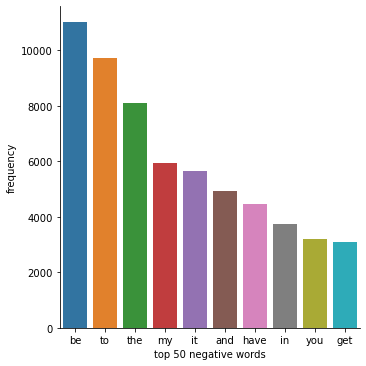

In [10]:
df1 = term_freq_df.sort_values(by='negative', ascending=False).head(10)
g = sns.catplot(x='index', y="negative", kind='bar', data=df1.reset_index())
g.set_axis_labels('top 50 negative words', 'frequency')
plt.show()

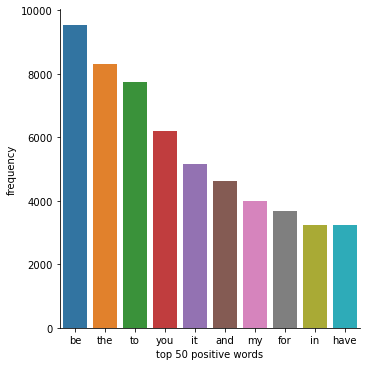

In [11]:
df2 = term_freq_df.sort_values(by='positive', ascending=False).head(10)
g = sns.catplot(x='index', y="positive", kind='bar', data=df2.reset_index())
g.set_axis_labels('top 50 positive words', 'frequency')
plt.show()

# Linear Classifier

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [13]:
vectorizer = CountVectorizer(min_df=0.001)

X = df.text.to_list()
Y = df.sentiment.to_list()

X_vec = vectorizer.fit_transform(X).toarray()

In [14]:
X_train, X_test, y_train, y_test  = train_test_split(
        X_vec, 
        Y,
        train_size=0.80,
        random_state=1234)

In [15]:
log_model= LogisticRegression()
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)

C:\Users\pasqu\anaconda3\envs\data-2A\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
confusion_matrix(y_test, y_pred)

array([[3631, 1315],
       [1066, 3988]], dtype=int64)

In [17]:
def conf_matrix(y_pred, y_test, model):
    sc_accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)
    sc_f1 = sklearn.metrics.f1_score(y_pred, y_test, pos_label="Positive")
    sc_recall = sklearn.metrics.recall_score(y_pred, y_test, pos_label="Positive")
    sc_precision = sklearn.metrics.precision_score(y_pred, y_test, pos_label="Positive")

    sklearn.metrics.plot_confusion_matrix(model, X_test, y_test)
    plt.show()

    print(f"Accuracy : {sc_accuracy}")
    print(f"Recall : {sc_recall}")
    print(f"Precision : {sc_precision}")
    print(f"F1 : {sc_f1}")

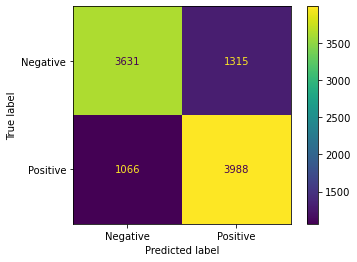

Accuracy : 0.7619
Recall : 0.7520271544408825
Precision : 0.7890779580530273
F1 : 0.7701071738920537


In [18]:
conf_matrix(y_pred, y_test, log_model)

In [19]:
'''
import random
j = random.randint(0,len(X_test)-7)
for i in range(j,j+7):
    print(y_pred[i])
    ind = X_vec.tolist().index(X_test[i].tolist())
    print(X[ind].strip())
'''

'\nimport random\nj = random.randint(0,len(X_test)-7)\nfor i in range(j,j+7):\n    print(y_pred[i])\n    ind = X_vec.tolist().index(X_test[i].tolist())\n    print(X[ind].strip())\n'

## Pipeline

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [21]:
# Fit to data and predict using pipelined LR.
reg = make_pipeline(LogisticRegression())
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

C:\Users\pasqu\anaconda3\envs\data-2A\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


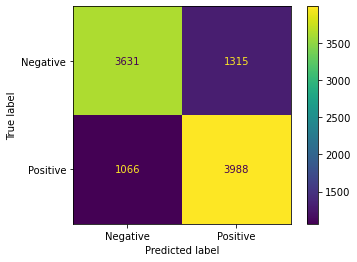

Accuracy : 0.7619
Recall : 0.7520271544408825
Precision : 0.7890779580530273
F1 : 0.7701071738920537


In [22]:
conf_matrix(y_pred, y_test, reg)

In [23]:
# Fit to data and predict using pipelined scaling, LR.
reg = make_pipeline(StandardScaler(), LogisticRegression())
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

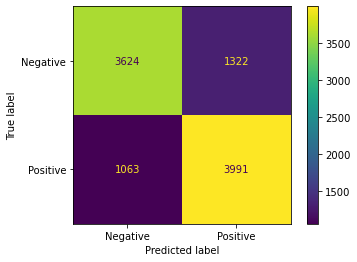

Accuracy : 0.7615
Recall : 0.751176359872012
Precision : 0.7896715472892758
F1 : 0.7699430886466674


In [24]:
conf_matrix(y_pred, y_test, reg)

In [25]:
# Fit to data and predict using pipelined scaling, LR and PCA.
reg = make_pipeline(StandardScaler(), PCA(n_components=50), LogisticRegression())
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

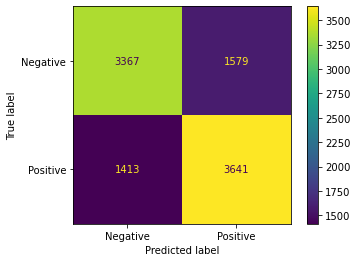

Accuracy : 0.7008
Recall : 0.6975095785440613
Precision : 0.7204194697269489
F1 : 0.7087794432548179


In [26]:
conf_matrix(y_pred, y_test, reg)

# Gaussian Naive Bayes

In [27]:
from sklearn.naive_bayes import GaussianNB

gauss = GaussianNB()
gauss.fit(X_train, y_train)
y_pred = gauss.predict(X_test)

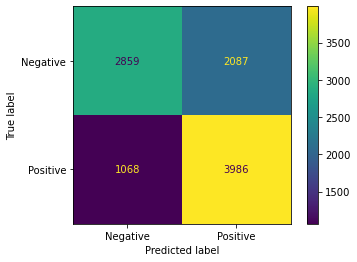

Accuracy : 0.6845
Recall : 0.6563477688127779
Precision : 0.7886822318955283
F1 : 0.7164554686797878


In [28]:
conf_matrix(y_pred, y_test, gauss)

In [29]:
# Fit to data and predict using pipelined scaling, GNB.
gauss = make_pipeline(StandardScaler(), GaussianNB())
gauss.fit(X_train, y_train)
y_pred = gauss.predict(X_test)

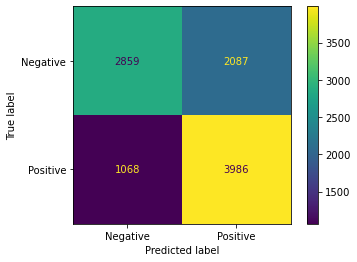

Accuracy : 0.6845
Recall : 0.6563477688127779
Precision : 0.7886822318955283
F1 : 0.7164554686797878


In [30]:
conf_matrix(y_pred, y_test, gauss)